In [45]:
import librosa
import librosa.display
import seaborn as sns
import numpy as np
import utility_functions as utils
import importlib
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # or RandomForestRegressor for regression tasks
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore", category=FutureWarning)
importlib.reload(utils)

<module 'utility_functions' from '/Users/borosabel/Documents/Uni/Thesis/PopMIR/Code/Audio/utility_functions.py'>

In [3]:
FRAME_LENGTH = 2048
HOP_LENGTH = 512

<b>Utility Functions, Data Loading and Data Preparation</b>

In [23]:
def compute_features(audio_path):
    y, sr = librosa.load(audio_path)

    #-- ZERO-CROSSING-RATE --
    zcrs = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
    zcr_mean = np.mean(zcrs)
    zcr_std = np.std(zcrs)
    # Create dictionary for DataFrame
    features_dict = {
        'ZCR Mean': zcr_mean,
        'ZCR Std': zcr_std
    }
    #-- ZERO-CROSSING-RATE --
    #-- RAW MEL SPECTOGRAM MEANs & STDs --
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    mel_mean = np.mean(S_dB, axis=1)
    mel_std = np.std(S_dB, axis=1)

    # Add Mel features
    for i, (mean, std) in enumerate(zip(mel_mean, mel_std)):
        features_dict[f'Raw_Melspect_Mean_{i}'] = mean
        features_dict[f'Raw_Melspect_Std_{i}'] = std

    #-- RAW MEL SPECTOGRAM MEANs & STDs --
    #-- RAW MFCC MEANs & STDs --
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)

    mfcc_means = np.mean(mfccs, axis=1)
    mfcc_stds = np.std(mfccs, axis=1)

    delta_mfccs_means = np.mean(delta_mfccs, axis=1)
    delta2_mfccs_means = np.mean(delta2_mfccs, axis=1)

    delta_mfccs_stds = np.std(delta_mfccs, axis=1)
    delta2_mfccs_stds = np.std(delta2_mfccs, axis=1)

    # Add MFCC features
    for i, (mean, std, delta_mean, delta_std, delta2_mean, delta2_std) in enumerate(zip(
            mfcc_means, mfcc_stds, delta_mfccs_means, delta_mfccs_stds, delta2_mfccs_means, delta2_mfccs_stds
    )):
        features_dict[f'Raw_MFCC_Mean_{i}'] = mean
        features_dict[f'Raw_MFCC_Std_{i}'] = std
        features_dict[f'Delta_MFCC_Mean_{i}'] = delta_mean
        features_dict[f'Delta_MFCC_Std_{i}'] = delta_std
        features_dict[f'Delta2_MFCC_Mean_{i}'] = delta2_mean
        features_dict[f'Delta2_MFCC_Std_{i}'] = delta2_std

    # Create a single-row DataFrame
    df_features = pd.DataFrame([features_dict])

    return df_features
    #-- RAW MFCC MEANs & STDs --

In [35]:
# Here I am just loading the saved progress because calculating everything would take like 2 days but above you can see the utility functions I used to calculate the features.
df = pd.read_excel('/Users/borosabel/Documents/Uni/Thesis/PopMIR/Code/Audio/output_w_everything.xlsx', engine='openpyxl')

In [36]:
labels = df[['Coast']]

# We need to drop columns which are not useful as a feature
columns_to_drop = ['FilePath', 'FileName', 'Duration (s)', 'Sample Rate (Hz)', 'Coast','Tempo2', 'Energy', 'Spectral Centroid', 'Spectral Rolloff', 'Spectral Bandwidth']
features = df.drop(columns_to_drop, axis=1)

We need to encode our labels as numbers because currently the look like this: 

In [37]:
labels.head()

,Coast
0,east_coast
1,east_coast
2,east_coast
3,east_coast
4,east_coast


In [38]:
le = LabelEncoder()
labels['Coast'] = le.fit_transform(labels['Coast'])

/var/folders/99/617f3z715_g8nc26tll89ddc0000gn/T/ipykernel_25554/2124155649.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['Coast'] = le.fit_transform(labels['Coast'])


In [39]:
labels

,Coast
0,0
1,0
2,0
3,0
4,0
...,...
1044,1
1045,1
1046,1
1047,1


<b>Model Training</b>

In [40]:
k = 10
# I use StratifiedKFold to keep the balance of the dataset consistent.
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

<b>Nearest Neighbors</b>

In [47]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

y_train = np.ravel(y_train)

# Define the range of k values to explore
k_values = np.arange(1, 16, 2)  # Odd integers from 1 to 15

# Define the KNN model
knn = KNeighborsClassifier()

# Perform grid search with cross-validation
param_grid = {'n_neighbors': k_values}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Retrieve the best k value
best_k = grid_search.best_params_['n_neighbors']
print("Best k value:", best_k)

# Evaluate the model with the best k value
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Validation accuracy with best k:", accuracy)

Best k value: 3
Validation accuracy with best k: 0.6904761904761905


<b>Random Forest</b>

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:  {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Cumulative Confusion Matrix:
[[375. 149.]
 [149. 376.]]


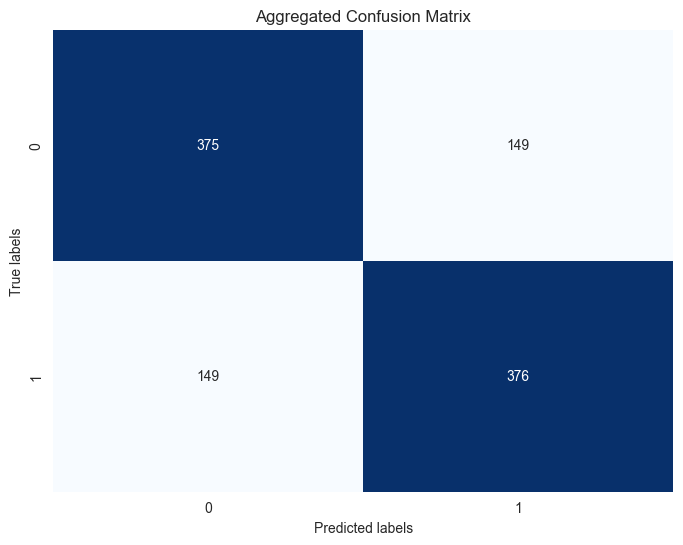

In [48]:
# Initialize your model
model = RandomForestClassifier(random_state=42)

# List to store each fold's accuracy
accuracy_scores = []

# Initialize an empty array to hold the sum of all confusion matrices
cumulative_conf_matrix = np.zeros((2, 2))  # Adjust the size if not binary classification

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Setup Grid Search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=1)

# Split your data
# Assuming features and labels are defined, and skf is your StratifiedKFold instance
for train_index, test_index in skf.split(features, labels):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]

    y_train = np.ravel(y_train)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_

    # Predict using the best model
    y_pred = best_model.predict(X_test)

    # Compute the confusion matrix and add it to the cumulative matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    cumulative_conf_matrix += conf_mat

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Print the cumulative confusion matrix
print("Cumulative Confusion Matrix:")
print(cumulative_conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cumulative_conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Aggregated Confusion Matrix')
plt.show()

In [42]:
importances = model.feature_importances_
feature_names = features.columns
feature_importance_dict = dict(zip(feature_names, importances))

# Optionally, convert to a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print(importance_df)

                  Feature  Importance
0                  Tempo1    0.032820
3     Raw_Melspect_Mean_0    0.014671
331      Raw_MFCC_Mean_12    0.010559
270     Delta2_MFCC_Std_1    0.009515
349      Raw_MFCC_Mean_15    0.007608
..                    ...         ...
80    Raw_Melspect_Std_38    0.000897
136   Raw_Melspect_Std_66    0.000879
179  Raw_Melspect_Mean_88    0.000877
81   Raw_Melspect_Mean_39    0.000866
63   Raw_Melspect_Mean_30    0.000776

[380 rows x 2 columns]
